In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [3]:
def getConfusionMatrix(labels: np.ndarray, predictions: np.ndarray):
    confusion = dict()
    confusion["TP"] = np.sum(labels & predictions)
    confusion["TN"] = np.sum(~labels & ~predictions)
    confusion["FP"] = np.sum(~labels & predictions)
    confusion["FN"] = np.sum(labels & ~predictions)
    return confusion

def getMetrics(confusion):
    metrics = dict()
    metrics["accuracy"] = (confusion["TP"] + confusion["TN"]) / (confusion["TP"] + confusion["TN"] + confusion["FP"] + confusion["FN"])
    metrics["precision"] = confusion["TP"] / (confusion["TP"] + confusion["FP"])
    metrics["recall"] = confusion["TP"] / (confusion["TP"] + confusion["FN"])
    metrics["f1"] = 2 * (metrics["precision"] * metrics["recall"]) / (metrics["precision"] + metrics["recall"])
    return metrics

def printMetrics(confusion):
    print("Accuracy: \t", confusion["accuracy"])
    print("Precision: \t", confusion["precision"])
    print("Recall: \t", confusion["recall"])
    print("F1: \t\t", confusion["f1"])

In [4]:
covid = pd.read_parquet('covidClean.parquet')

toRemove = ["PATIENT_ID", "USMER", "SYMPTOMS_DATE",
            "MEDICAL_UNIT", "ADMISSION_DATE", "PATIENT_TYPE",
            "DEATH_DATE", "ORIGIN_COUNTRY"]
covid = covid.drop(columns = toRemove)
covid = covid.drop(columns= ["DIED", "INTUBED", "ICU"])

trainingSet, testSet = train_test_split(covid, test_size = 0.25)

trainingY = np.array(trainingSet["AT_RISK"])
trainingX = trainingSet.drop(columns = ["AT_RISK"])

testY = np.array(testSet["AT_RISK"])
testX = testSet.drop(columns = ["AT_RISK"])

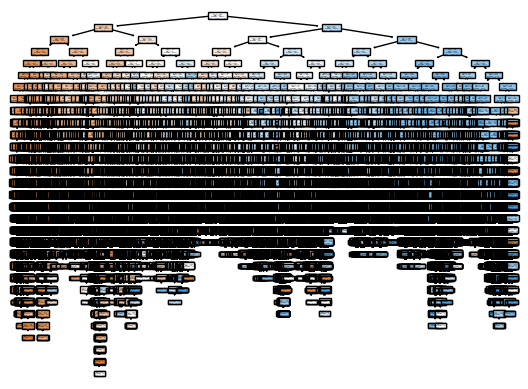

CART metrics:
Accuracy: 	 0.6317916273708477
Precision: 	 0.6304962930241998
Recall: 	 0.6763530647268257
F1: 		 0.6526201318561817


In [5]:
cart = DecisionTreeClassifier()

cart.fit(trainingX, trainingY)
plot_tree(cart, filled=True)
plt.show()

predictions = cart.predict(testX)

metric = getMetrics(getConfusionMatrix(testY, predictions))
print("CART metrics:")
printMetrics(metric)


## Pruning

In [ ]:
path = cart.cost_complexity_pruning_path(trainingX, trainingY)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[ccp_alphas >= 0]

dimChunks = 1000
chunks = np.split(ccp_alphas, [i for i in range(dimChunks, len(ccp_alphas), dimChunks)])

accuracyTest, accuracyTrain = [], []
def getTreePerf(ccp_alpha):
    clf = DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(trainingX, trainingY)
    predictionTrain = clf.predict(trainingX)
    predictionTest = clf.predict(testX)
    accuracyTrain.append(getMetrics(getConfusionMatrix(trainingY, predictionTrain))["accuracy"])
    accuracyTest.append(getMetrics(getConfusionMatrix(testY, predictionTest))["accuracy"])
    return

for chunk in chunks:
    joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(getTreePerf)(ccp_alpha) for ccp_alpha in chunk)

plt.figure(figsize=(10, 5))
plt.plot(ccp_alphas, accuracyTrain, marker='o', label="train", drawstyle="steps-post")
plt.plot(ccp_alphas, accuracyTest, marker='o', label="test", drawstyle="steps-post")
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.legend()
plt.show()